Xiang Zhang, Junbo Zhao, Yann LeCun: Character-level Convolutional Networks for Text Classification   
(https://arxiv.org/abs/1509.01626)

In [2]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
import json

try:
    if get_ipython().__class__.__name__ == 'ZMQInteractiveShell':
        print("tqdm is notebook version")
        from tqdm import tqdm_notebook as tqdm
    else:
        raise RuntimeError
except (NameError, RuntimeError):
    from tqdm import tqdm
    
%load_ext jupyternotify

tqdm is notebook version
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [3]:
def extract_end(char_seq):
    char_seq_length = 600 #1014
    if len(char_seq) > char_seq_length:
        char_seq = char_seq[-char_seq_length:]
    return char_seq


def pad_sentence(char_seq, padding_char=" "):
    char_seq_length = 600
    num_padding = char_seq_length - len(char_seq)
    new_char_seq = char_seq + [padding_char] * num_padding
    return new_char_seq


def string_to_int8_conversion(char_seq, alphabet):
    x = np.array([alphabet.find(char) for char in char_seq], dtype=np.int8)
    return x


def get_batched_one_hot(char_seqs_indices, labels, start_index, end_index):
    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}\n"
    x_batch = char_seqs_indices[start_index:end_index]
    y_batch = labels[start_index:end_index]
    x_batch_one_hot = np.zeros(shape=[len(x_batch), len(alphabet), len(x_batch[0]), 1])
    for example_i, char_seq_indices in enumerate(x_batch):
        for char_pos_in_seq, char_seq_char_ind in enumerate(char_seq_indices):
            if char_seq_char_ind != -1:
                x_batch_one_hot[example_i][char_seq_char_ind][char_pos_in_seq][0] = 1
    return [x_batch_one_hot, y_batch]


def batch_iter(x, y, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    # data = np.array(data)
    data_size = len(x)
    num_batches_per_epoch = int(data_size/batch_size) + 1
    for epoch in range(num_epochs):
        print("In epoch >> " + str(epoch + 1))
        print("num batches per epoch is: " + str(num_batches_per_epoch))
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            x_shuffled = x[shuffle_indices]
            y_shuffled = y[shuffle_indices]
        else:
            x_shuffled = x
            y_shuffled = y
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            x_batch, y_batch = get_batched_one_hot(x_shuffled, y_shuffled, start_index, end_index)
            batch = list(zip(x_batch, y_batch))
            yield batch

In [4]:
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0

batch_size = 128
num_epochs = 50
evaluate_every = 5000
checkpoint_every = 1000

# Misc Parameters
allow_soft_placement = True #"Allow device soft device placement")
log_device_placement = False  #, "Log placement of ops on devices")

In [5]:
positive_data_file = "data/amazon/book_pos.txt"
negative_data_file = "data/amazon/book_neg.txt"

In [6]:
dev_sample_percentage = 0.0005

In [7]:
def _load_data(file_path, examples, raw):
    with open(file_path) as f:
        for line in tqdm(f):
            text = line
            raw.append(text)
            text_end_extracted = extract_end(list(text.lower()))
            padded = pad_sentence(text_end_extracted)
            text_int8_repr = string_to_int8_conversion(padded, alphabet)           
            examples.append(text_int8_repr)
    return examples, raw

def load_data(positive_file_path, negative_data_file, alphabet):
    pos_examples = [] 
    pos_raw = []
    neg_examples = []
    neg_raw = []
    
    _load_data(positive_data_file, pos_examples, pos_raw)
    _load_data(negative_data_file, neg_examples, neg_raw)
    
    n_posi = len(pos_examples)
    print("# of positive", n_posi)
    n_neg = len(neg_examples)
    print("# of negative", n_neg)
    
    positive_labels = [[0, 1] for _ in range(n_posi)]
    negative_labels = [[1, 0] for _ in range(n_neg)]
    
    labels = positive_labels + negative_labels
    examples = pos_examples + neg_examples
    
    return np.array(examples, dtype=np.int8), np.array(labels, dtype=np.int8), pos_raw+neg_raw

In [8]:
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}\n"

In [9]:
%%notify
x, y, raw = load_data(positive_data_file, negative_data_file, alphabet)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


# of positive 500000
# of negative 500000


<IPython.core.display.Javascript object>

In [10]:
x[1]

array([19,  7,  4, -1, 18, 19, 14, 17, 24, 11,  8, 13,  4, -1,  8, 18, -1,
        6, 17,  4,  0, 19, 39, -1, -1, 22, 14, 20, 11,  3, -1,  7,  0, 21,
        4, -1,  1,  4,  4, 13, -1, 12, 20,  2,  7, -1, 12, 14, 17,  4, -1,
        4, 13,  9, 14, 24,  0,  1, 11,  4, -1,  8,  5, -1,  8, 19, -1,  7,
        0,  3, -1,  1,  4,  4, 13, -1,  1,  4, 19, 19,  4, 17, -1, 15, 17,
       14, 14,  5,  4,  3, -1, 36, -1, 19,  7,  4, -1, 12,  0, 13, 24, -1,
       19, 24, 15, 14, 18, -1,  0, 13,  3, -1, 18, 24, 13, 19,  0, 23, -1,
        4, 17, 17, 14, 17, 18, -1,  0, 13,  3, -1,  8, 13,  2, 14, 17, 17,
        4,  2, 19, -1, 20, 18,  4, -1, 14,  5, -1, 22, 14, 17,  3, 18, -1,
       12,  0,  3,  4, -1,  5, 14, 17, -1,  0, -1, 18, 11, 14, 15, 15, 24,
       -1,  0, 13,  3, -1,  3,  8, 18, 19, 17,  0,  2, 19,  8, 13,  6, -1,
       17,  4,  0,  3, 39, -1, -1,  8, 13, -1, 18, 15,  8, 19,  4, -1, 14,
        5, -1, 19,  7,  8, 18, -1,  0, 12, -1, 11, 14, 14, 10,  8, 13,  6,
       -1,  5, 14, 17, 22

In [11]:
raw[1]

'The storyline is great.  Would have been much more enjoyable if it had been better proofed - the many typos and syntax errors and incorrect use of words made for a sloppy and distracting read.  In spite of this am looking forward to the sequel.\n'

In [12]:
y[1]

array([0, 1], dtype=int8)

In [13]:
x.shape

(1000000, 600)

In [14]:
y.shape

(1000000, 2)

In [15]:
length_list = np.array([len(r)for r in raw])
length_list.mean()

514.629429

In [16]:
import pandas as pd
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,116
1,245
2,368
3,131
4,139


In [17]:
df.describe()

,length
count,1000000.000000
mean,514.629429
std,682.247415
min,1.000000
25%,155.000000
50%,273.000000
75%,570.000000
max,29656.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x182ea51a20>]],
      dtype=object)

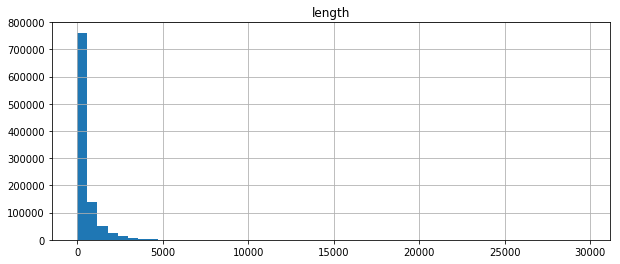

In [18]:
%matplotlib inline
df.hist(bins=50,figsize=(10,4))

In [19]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

dev_sample_index = -1 * int(dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Train/Dev split: 999500/500


<IPython.core.display.Javascript object>

In [22]:
class CharCNN(object):
    """
    A CNN for text classification.
    based on the Character-level Convolutional Networks for Text Classification paper.
    """
    def __init__(self, num_classes=2, filter_sizes=(7, 7, 3, 3, 3, 3), num_filters_per_size=256,
                 l2_reg_lambda=0.0, sequence_max_length=1014, num_quantized_chars=70):

        self.input_x = tf.placeholder(tf.float32, [None, num_quantized_chars, sequence_max_length, 1], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

    
        l2_loss = tf.constant(0.0)

        # ================ Layer 1 ================
        with tf.name_scope("conv-maxpool-1"):
            filter_shape = [num_quantized_chars, filter_sizes[0], 1, num_filters_per_size]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_filters_per_size]), name="b")
            conv = tf.nn.conv2d(self.input_x, W, strides=[1, 1, 1, 1], padding="VALID", name="conv1")
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            pooled = tf.nn.max_pool(h, ksize=[1, 1, 3, 1], strides=[1, 1, 3, 1], padding='VALID', name="pool1")

        # ================ Layer 2 ================
        with tf.name_scope("conv-maxpool-2"):
            filter_shape = [1, filter_sizes[1], num_filters_per_size, num_filters_per_size]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_filters_per_size]), name="b")
            conv = tf.nn.conv2d(pooled, W, strides=[1, 1, 1, 1], padding="VALID", name="conv2")
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            pooled = tf.nn.max_pool(h, ksize=[1, 1, 3, 1], strides=[1, 1, 3, 1], padding='VALID', name="pool2")

        # ================ Layer 3 ================
        with tf.name_scope("conv-3"):
            filter_shape = [1, filter_sizes[2], num_filters_per_size, num_filters_per_size]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_filters_per_size]), name="b")
            conv = tf.nn.conv2d(pooled, W, strides=[1, 1, 1, 1], padding="VALID", name="conv3")
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")

        # ================ Layer 4 ================
        with tf.name_scope("conv-4"):
            filter_shape = [1, filter_sizes[3], num_filters_per_size, num_filters_per_size]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_filters_per_size]), name="b")
            conv = tf.nn.conv2d(h, W, strides=[1, 1, 1, 1], padding="VALID", name="conv4")
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")

        # ================ Layer 5 ================
        with tf.name_scope("conv-5"):
            filter_shape = [1, filter_sizes[4], num_filters_per_size, num_filters_per_size]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_filters_per_size]), name="b")
            conv = tf.nn.conv2d(h, W, strides=[1, 1, 1, 1], padding="VALID", name="conv5")
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")

        # ================ Layer 6 ================
        with tf.name_scope("conv-maxpool-6"):
            filter_shape = [1, filter_sizes[5], num_filters_per_size, num_filters_per_size]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_filters_per_size]), name="b")
            conv = tf.nn.conv2d(h, W, strides=[1, 1, 1, 1], padding="VALID", name="conv6")
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            pooled = tf.nn.max_pool(h, ksize=[1, 1, 3, 1], strides=[1, 1, 3, 1], padding='VALID', name="pool6")

        # ================ Layer 7 ================
        num_features_total = num_filters_per_size * 18 #34
        print("######")
        print(num_features_total)
        print(pooled.shape)
        print("#############")
        h_pool_flat = tf.reshape(pooled, [-1, num_features_total])

        # Add dropout
        with tf.name_scope("dropout-1"):
            drop1 = tf.nn.dropout(h_pool_flat, self.dropout_keep_prob)

        # Fully connected layer 1
        with tf.name_scope("fc-1"):
            size = 64#1024
            W = tf.Variable(tf.truncated_normal([num_features_total, size], stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[size]), name="b")
            # l2_loss += tf.nn.l2_loss(W)
            # l2_loss += tf.nn.l2_loss(b)

            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(drop1, W, b), name="fc-1-out")

        # ================ Layer 8 ================
        # Add dropout
        with tf.name_scope("dropout-2"):
            drop2 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)

        # Fully connected layer 2
        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([size, size], stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[size]), name="b")
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop2, W, b), name="fc-2-out")

        # ================ Layer 9 ================
        # Fully connected layer 3
        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([size, num_classes], stddev=0.05), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            scores = tf.nn.xw_plus_b(fc_2_output, W, b, name="output")
            predictions = tf.argmax(scores, 1, name="predictions")
            
            

        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss



        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")


In [23]:
with tf.Graph().as_default() as g:
    session_conf = tf.ConfigProto(allow_soft_placement=allow_soft_placement, log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        
        cnn = CharCNN(sequence_max_length=600)

        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)


        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)


        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

    
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.global_variables())

        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            dev_size = len(x_batch)
            max_batch_size = 500
            num_batches = dev_size/max_batch_size
            acc = []
            losses = []
            print("Number of batches in dev set is " + str(num_batches))
            for i in range(num_batches):
                x_batch_dev, y_batch_dev = get_batched_one_hot(x_batch, y_batch, i * max_batch_size, (i + 1) * max_batch_size)
                feed_dict = {
                  cnn.input_x: x_batch_dev,
                  cnn.input_y: y_batch_dev,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run([global_step, dev_summary_op, cnn.loss, cnn.accuracy], feed_dict)
                acc.append(accuracy)
                losses.append(loss)
                time_str = datetime.datetime.now().isoformat()
                print("batch " + str(i + 1) + " in dev >>" +
                      " {}: loss {:g}, acc {:g}".format(time_str, loss, accuracy))
                if writer:
                    writer.add_summary(summaries, step)
            print("\nMean accuracy=" + str(sum(acc)/len(acc)))
            print("Mean loss=" + str(sum(losses)/len(losses)))


        for batch in batch_iter(x_train, y_train, batch_size, num_epochs):
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % checkpoint_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

######
4608
(?, 1, 18, 256)
#############
INFO:tensorflow:Summary name conv-maxpool-1/W:0/grad/hist is illegal; using conv-maxpool-1/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-1/W:0/grad/sparsity is illegal; using conv-maxpool-1/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-1/b:0/grad/hist is illegal; using conv-maxpool-1/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-1/b:0/grad/sparsity is illegal; using conv-maxpool-1/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflo

2018-05-04T11:06:12.518043: step 68, loss 0.694034, acc 0.5
2018-05-04T11:06:14.393821: step 69, loss 0.696816, acc 0.445312
2018-05-04T11:06:16.478662: step 70, loss 0.695648, acc 0.4375
2018-05-04T11:06:18.705520: step 71, loss 0.690839, acc 0.5625
2018-05-04T11:06:20.986909: step 72, loss 0.693281, acc 0.515625
2018-05-04T11:06:23.242042: step 73, loss 0.691592, acc 0.539062
2018-05-04T11:06:25.667599: step 74, loss 0.691754, acc 0.5625
2018-05-04T11:06:28.170972: step 75, loss 0.694833, acc 0.492188
2018-05-04T11:06:30.795499: step 76, loss 0.692072, acc 0.507812
2018-05-04T11:06:33.613756: step 77, loss 0.686937, acc 0.5625
2018-05-04T11:06:36.305230: step 78, loss 0.69454, acc 0.484375
2018-05-04T11:06:38.952216: step 79, loss 0.695916, acc 0.5
2018-05-04T11:06:41.727134: step 80, loss 0.693053, acc 0.539062
2018-05-04T11:06:44.596163: step 81, loss 0.703147, acc 0.367188
2018-05-04T11:06:48.325178: step 82, loss 0.697387, acc 0.460938
2018-05-04T11:06:53.561481: step 83, loss 0.

2018-05-04T11:11:03.560538: step 195, loss 0.692523, acc 0.515625
2018-05-04T11:11:05.362877: step 196, loss 0.69363, acc 0.484375
2018-05-04T11:11:07.150291: step 197, loss 0.694556, acc 0.484375
2018-05-04T11:11:08.947017: step 198, loss 0.693419, acc 0.5
2018-05-04T11:11:10.782138: step 199, loss 0.693188, acc 0.507812
2018-05-04T11:11:12.612528: step 200, loss 0.693395, acc 0.492188
2018-05-04T11:11:14.471049: step 201, loss 0.69422, acc 0.445312
2018-05-04T11:11:16.325222: step 202, loss 0.693269, acc 0.46875
2018-05-04T11:11:18.235059: step 203, loss 0.693111, acc 0.492188
2018-05-04T11:11:20.141450: step 204, loss 0.692802, acc 0.539062
2018-05-04T11:11:22.105323: step 205, loss 0.693492, acc 0.53125
2018-05-04T11:11:23.989594: step 206, loss 0.694628, acc 0.398438
2018-05-04T11:11:25.877650: step 207, loss 0.692601, acc 0.609375
2018-05-04T11:11:27.785540: step 208, loss 0.692119, acc 0.554688
2018-05-04T11:11:29.639226: step 209, loss 0.694495, acc 0.453125
2018-05-04T11:11:31

2018-05-04T11:15:11.180719: step 321, loss 0.691783, acc 0.546875
2018-05-04T11:15:12.967087: step 322, loss 0.691662, acc 0.507812
2018-05-04T11:15:14.747208: step 323, loss 0.69488, acc 0.484375
2018-05-04T11:15:16.497888: step 324, loss 0.694139, acc 0.492188
2018-05-04T11:15:18.266865: step 325, loss 0.696197, acc 0.46875
2018-05-04T11:15:20.020759: step 326, loss 0.693167, acc 0.554688
2018-05-04T11:15:21.776884: step 327, loss 0.698726, acc 0.46875
2018-05-04T11:15:23.528624: step 328, loss 0.693389, acc 0.492188
2018-05-04T11:15:25.376140: step 329, loss 0.69625, acc 0.460938
2018-05-04T11:15:27.240986: step 330, loss 0.693794, acc 0.507812
2018-05-04T11:15:29.037792: step 331, loss 0.693796, acc 0.5
2018-05-04T11:15:30.838404: step 332, loss 0.696213, acc 0.453125
2018-05-04T11:15:32.629724: step 333, loss 0.693574, acc 0.476562
2018-05-04T11:15:34.441456: step 334, loss 0.692276, acc 0.570312
2018-05-04T11:15:36.259372: step 335, loss 0.6935, acc 0.460938
2018-05-04T11:15:38.0

2018-05-04T11:19:09.293580: step 447, loss 0.69227, acc 0.523438
2018-05-04T11:19:11.301340: step 448, loss 0.693712, acc 0.429688
2018-05-04T11:19:13.266591: step 449, loss 0.693658, acc 0.46875
2018-05-04T11:19:15.167432: step 450, loss 0.693347, acc 0.5
2018-05-04T11:19:17.071796: step 451, loss 0.693536, acc 0.46875
2018-05-04T11:19:18.968017: step 452, loss 0.692946, acc 0.53125
2018-05-04T11:19:20.880760: step 453, loss 0.694211, acc 0.46875
2018-05-04T11:19:22.782182: step 454, loss 0.693705, acc 0.453125
2018-05-04T11:19:24.694208: step 455, loss 0.694129, acc 0.421875
2018-05-04T11:19:26.660156: step 456, loss 0.693247, acc 0.523438
2018-05-04T11:19:28.623677: step 457, loss 0.693055, acc 0.539062
2018-05-04T11:19:30.557645: step 458, loss 0.693233, acc 0.507812
2018-05-04T11:19:32.474295: step 459, loss 0.693203, acc 0.515625
2018-05-04T11:19:34.705511: step 460, loss 0.693435, acc 0.476562
2018-05-04T11:19:36.868298: step 461, loss 0.692817, acc 0.53125
2018-05-04T11:19:38.8

2018-05-04T11:23:05.012635: step 573, loss 0.694416, acc 0.382812
2018-05-04T11:23:06.946740: step 574, loss 0.694401, acc 0.445312
2018-05-04T11:23:08.897295: step 575, loss 0.693987, acc 0.46875
2018-05-04T11:23:10.828905: step 576, loss 0.692743, acc 0.5625
2018-05-04T11:23:12.721179: step 577, loss 0.693512, acc 0.5
2018-05-04T11:23:14.637152: step 578, loss 0.693436, acc 0.476562
2018-05-04T11:23:16.539591: step 579, loss 0.692804, acc 0.445312
2018-05-04T11:23:18.434895: step 580, loss 0.693123, acc 0.5
2018-05-04T11:23:20.328725: step 581, loss 0.691838, acc 0.632812
2018-05-04T11:23:22.240197: step 582, loss 0.692245, acc 0.546875
2018-05-04T11:23:24.147408: step 583, loss 0.692802, acc 0.5
2018-05-04T11:23:26.041770: step 584, loss 0.693655, acc 0.476562
2018-05-04T11:23:27.953376: step 585, loss 0.693893, acc 0.492188
2018-05-04T11:23:29.953074: step 586, loss 0.694045, acc 0.492188
2018-05-04T11:23:31.905712: step 587, loss 0.695786, acc 0.414062
2018-05-04T11:23:33.887213: 

2018-05-04T11:27:12.041918: step 699, loss 0.691744, acc 0.5
2018-05-04T11:27:13.881000: step 700, loss 0.701339, acc 0.476562
2018-05-04T11:27:15.701241: step 701, loss 0.690195, acc 0.554688
2018-05-04T11:27:17.534881: step 702, loss 0.691988, acc 0.507812
2018-05-04T11:27:19.314893: step 703, loss 0.703191, acc 0.4375
2018-05-04T11:27:21.096996: step 704, loss 0.70164, acc 0.453125
2018-05-04T11:27:22.884875: step 705, loss 0.700795, acc 0.429688
2018-05-04T11:27:24.662325: step 706, loss 0.693408, acc 0.507812
2018-05-04T11:27:26.491341: step 707, loss 0.694662, acc 0.546875
2018-05-04T11:27:28.316499: step 708, loss 0.693051, acc 0.515625
2018-05-04T11:27:30.105853: step 709, loss 0.694225, acc 0.46875
2018-05-04T11:27:31.964270: step 710, loss 0.693922, acc 0.46875
2018-05-04T11:27:33.756812: step 711, loss 0.693578, acc 0.460938
2018-05-04T11:27:35.557186: step 712, loss 0.693757, acc 0.453125
2018-05-04T11:27:37.343483: step 713, loss 0.694149, acc 0.421875
2018-05-04T11:27:39.

2018-05-04T11:31:05.951525: step 825, loss 0.692756, acc 0.507812
2018-05-04T11:31:07.674378: step 826, loss 0.693114, acc 0.507812
2018-05-04T11:31:09.380193: step 827, loss 0.692957, acc 0.507812
2018-05-04T11:31:11.031665: step 828, loss 0.695403, acc 0.46875
2018-05-04T11:31:12.617701: step 829, loss 0.692309, acc 0.53125
2018-05-04T11:31:14.162428: step 830, loss 0.694036, acc 0.484375
2018-05-04T11:31:15.715604: step 831, loss 0.692629, acc 0.515625
2018-05-04T11:31:17.406736: step 832, loss 0.693867, acc 0.476562
2018-05-04T11:31:19.120293: step 833, loss 0.697671, acc 0.375
2018-05-04T11:31:20.823080: step 834, loss 0.694873, acc 0.445312
2018-05-04T11:31:22.559171: step 835, loss 0.694434, acc 0.46875
2018-05-04T11:31:24.389262: step 836, loss 0.693815, acc 0.4375
2018-05-04T11:31:26.163457: step 837, loss 0.692403, acc 0.546875
2018-05-04T11:31:27.962820: step 838, loss 0.69355, acc 0.523438
2018-05-04T11:31:29.989206: step 839, loss 0.692614, acc 0.5625
2018-05-04T11:31:32.0

2018-05-04T11:34:55.701379: step 951, loss 0.695177, acc 0.46875
2018-05-04T11:34:57.505559: step 952, loss 0.691377, acc 0.539062
2018-05-04T11:34:59.305291: step 953, loss 0.694357, acc 0.492188
2018-05-04T11:35:01.116743: step 954, loss 0.696225, acc 0.46875
2018-05-04T11:35:02.887085: step 955, loss 0.6938, acc 0.460938
2018-05-04T11:35:04.665403: step 956, loss 0.694097, acc 0.46875
2018-05-04T11:35:06.462871: step 957, loss 0.692917, acc 0.523438
2018-05-04T11:35:08.159543: step 958, loss 0.692683, acc 0.492188
2018-05-04T11:35:09.852801: step 959, loss 0.69145, acc 0.539062
2018-05-04T11:35:11.636340: step 960, loss 0.690859, acc 0.546875
2018-05-04T11:35:13.373877: step 961, loss 0.690853, acc 0.554688
2018-05-04T11:35:15.172888: step 962, loss 0.700846, acc 0.453125
2018-05-04T11:35:17.070965: step 963, loss 0.693197, acc 0.5
2018-05-04T11:35:18.842960: step 964, loss 0.690252, acc 0.578125
2018-05-04T11:35:20.623870: step 965, loss 0.683215, acc 0.617188
2018-05-04T11:35:22.4

2018-05-04T11:38:33.802952: step 1074, loss 0.695104, acc 0.476562
2018-05-04T11:38:35.501744: step 1075, loss 0.693439, acc 0.484375
2018-05-04T11:38:37.185041: step 1076, loss 0.692759, acc 0.53125
2018-05-04T11:38:38.883504: step 1077, loss 0.692773, acc 0.515625
2018-05-04T11:38:40.594355: step 1078, loss 0.692058, acc 0.523438
2018-05-04T11:38:42.325318: step 1079, loss 0.693934, acc 0.484375
2018-05-04T11:38:44.030943: step 1080, loss 0.693527, acc 0.5
2018-05-04T11:38:45.715564: step 1081, loss 0.687972, acc 0.601562
2018-05-04T11:38:47.462769: step 1082, loss 0.693277, acc 0.5
2018-05-04T11:38:49.408198: step 1083, loss 0.691479, acc 0.53125
2018-05-04T11:38:51.112749: step 1084, loss 0.694359, acc 0.507812
2018-05-04T11:38:52.851903: step 1085, loss 0.695811, acc 0.46875
2018-05-04T11:38:54.566365: step 1086, loss 0.693448, acc 0.515625
2018-05-04T11:38:56.272515: step 1087, loss 0.697025, acc 0.429688
2018-05-04T11:38:57.966775: step 1088, loss 0.691534, acc 0.523438
2018-05-

2018-05-04T11:42:09.086926: step 1198, loss 0.695852, acc 0.414062
2018-05-04T11:42:10.834666: step 1199, loss 0.693961, acc 0.515625
2018-05-04T11:42:12.575050: step 1200, loss 0.693147, acc 0.523438
2018-05-04T11:42:14.135330: step 1201, loss 0.692488, acc 0.523438
2018-05-04T11:42:15.707121: step 1202, loss 0.694212, acc 0.476562
2018-05-04T11:42:17.380961: step 1203, loss 0.693344, acc 0.515625
2018-05-04T11:42:19.144998: step 1204, loss 0.692988, acc 0.507812
2018-05-04T11:42:20.998647: step 1205, loss 0.693157, acc 0.460938
2018-05-04T11:42:22.793360: step 1206, loss 0.691889, acc 0.585938
2018-05-04T11:42:24.551161: step 1207, loss 0.693722, acc 0.5
2018-05-04T11:42:26.316319: step 1208, loss 0.693809, acc 0.453125
2018-05-04T11:42:28.102778: step 1209, loss 0.69329, acc 0.484375
2018-05-04T11:42:29.887711: step 1210, loss 0.694226, acc 0.445312
2018-05-04T11:42:31.636352: step 1211, loss 0.693323, acc 0.492188
2018-05-04T11:42:33.488966: step 1212, loss 0.693006, acc 0.539062
2

2018-05-04T11:46:10.302273: step 1322, loss 0.693325, acc 0.484375
2018-05-04T11:46:11.938653: step 1323, loss 0.693156, acc 0.5
2018-05-04T11:46:13.495944: step 1324, loss 0.692976, acc 0.523438
2018-05-04T11:46:15.179927: step 1325, loss 0.692901, acc 0.539062
2018-05-04T11:46:16.866358: step 1326, loss 0.692672, acc 0.578125
2018-05-04T11:46:18.569621: step 1327, loss 0.693492, acc 0.445312
2018-05-04T11:46:20.291805: step 1328, loss 0.693393, acc 0.46875
2018-05-04T11:46:22.056249: step 1329, loss 0.692753, acc 0.570312
2018-05-04T11:46:23.773804: step 1330, loss 0.69269, acc 0.570312
2018-05-04T11:46:25.547833: step 1331, loss 0.692944, acc 0.523438
2018-05-04T11:46:27.315431: step 1332, loss 0.693586, acc 0.460938
2018-05-04T11:46:29.028899: step 1333, loss 0.69273, acc 0.539062
2018-05-04T11:46:30.797120: step 1334, loss 0.693365, acc 0.484375
2018-05-04T11:46:32.523767: step 1335, loss 0.693702, acc 0.460938
2018-05-04T11:46:34.410690: step 1336, loss 0.693834, acc 0.453125
201

2018-05-04T11:49:43.861990: step 1446, loss 0.69327, acc 0.484375
2018-05-04T11:49:45.569370: step 1447, loss 0.69341, acc 0.476562
2018-05-04T11:49:47.268250: step 1448, loss 0.692972, acc 0.515625
2018-05-04T11:49:48.987905: step 1449, loss 0.693049, acc 0.507812
2018-05-04T11:49:50.734962: step 1450, loss 0.692517, acc 0.546875
2018-05-04T11:49:52.463955: step 1451, loss 0.693309, acc 0.492188
2018-05-04T11:49:54.181996: step 1452, loss 0.692783, acc 0.523438
2018-05-04T11:49:55.887291: step 1453, loss 0.69422, acc 0.445312
2018-05-04T11:49:57.620321: step 1454, loss 0.693367, acc 0.492188
2018-05-04T11:49:59.353535: step 1455, loss 0.69382, acc 0.46875
2018-05-04T11:50:01.080541: step 1456, loss 0.693345, acc 0.492188
2018-05-04T11:50:02.909008: step 1457, loss 0.694042, acc 0.453125
2018-05-04T11:50:04.632935: step 1458, loss 0.693961, acc 0.453125
2018-05-04T11:50:06.368622: step 1459, loss 0.693413, acc 0.484375
2018-05-04T11:50:08.082373: step 1460, loss 0.692895, acc 0.523438


2018-05-04T11:53:25.469835: step 1570, loss 0.69324, acc 0.5
2018-05-04T11:53:27.263248: step 1571, loss 0.6934, acc 0.492188
2018-05-04T11:53:29.051646: step 1572, loss 0.693852, acc 0.46875
2018-05-04T11:53:30.828250: step 1573, loss 0.693777, acc 0.46875
2018-05-04T11:53:32.600866: step 1574, loss 0.692663, acc 0.53125
2018-05-04T11:53:34.398615: step 1575, loss 0.692594, acc 0.539062
2018-05-04T11:53:36.177672: step 1576, loss 0.693602, acc 0.46875
2018-05-04T11:53:37.954251: step 1577, loss 0.692984, acc 0.515625
2018-05-04T11:53:39.845839: step 1578, loss 0.692895, acc 0.523438
2018-05-04T11:53:41.736585: step 1579, loss 0.69274, acc 0.539062
2018-05-04T11:53:43.507380: step 1580, loss 0.69313, acc 0.5
2018-05-04T11:53:45.296633: step 1581, loss 0.69308, acc 0.507812
2018-05-04T11:53:47.091855: step 1582, loss 0.693332, acc 0.484375
2018-05-04T11:53:48.879603: step 1583, loss 0.693403, acc 0.476562
2018-05-04T11:53:50.648408: step 1584, loss 0.69323, acc 0.492188
2018-05-04T11:53

2018-05-04T11:57:09.924661: step 1694, loss 0.693135, acc 0.507812
2018-05-04T11:57:11.695666: step 1695, loss 0.693228, acc 0.484375
2018-05-04T11:57:13.459038: step 1696, loss 0.69313, acc 0.5
2018-05-04T11:57:15.247793: step 1697, loss 0.693199, acc 0.507812
2018-05-04T11:57:17.156805: step 1698, loss 0.693071, acc 0.515625
2018-05-04T11:57:18.962360: step 1699, loss 0.693239, acc 0.476562
2018-05-04T11:57:20.810598: step 1700, loss 0.693259, acc 0.476562
2018-05-04T11:57:22.618607: step 1701, loss 0.693437, acc 0.429688
2018-05-04T11:57:24.416978: step 1702, loss 0.693105, acc 0.507812
2018-05-04T11:57:26.185199: step 1703, loss 0.693062, acc 0.546875
2018-05-04T11:57:27.963923: step 1704, loss 0.693093, acc 0.515625
2018-05-04T11:57:29.741498: step 1705, loss 0.693222, acc 0.492188
2018-05-04T11:57:31.542996: step 1706, loss 0.693096, acc 0.523438
2018-05-04T11:57:33.326050: step 1707, loss 0.693171, acc 0.46875
2018-05-04T11:57:35.115322: step 1708, loss 0.69311, acc 0.515625
201

2018-05-04T12:01:08.584347: step 1818, loss 0.6933, acc 0.492188
2018-05-04T12:01:10.506839: step 1819, loss 0.692925, acc 0.507812
2018-05-04T12:01:12.567075: step 1820, loss 0.692037, acc 0.554688
2018-05-04T12:01:14.583579: step 1821, loss 0.69353, acc 0.484375
2018-05-04T12:01:16.603917: step 1822, loss 0.693614, acc 0.484375
2018-05-04T12:01:18.640085: step 1823, loss 0.692556, acc 0.546875
2018-05-04T12:01:20.637709: step 1824, loss 0.692335, acc 0.554688
2018-05-04T12:01:22.616468: step 1825, loss 0.693965, acc 0.445312
2018-05-04T12:01:24.738144: step 1826, loss 0.69426, acc 0.429688
2018-05-04T12:01:26.821244: step 1827, loss 0.693139, acc 0.5
2018-05-04T12:01:28.827775: step 1828, loss 0.69395, acc 0.4375
2018-05-04T12:01:30.808134: step 1829, loss 0.693174, acc 0.492188
2018-05-04T12:01:33.011991: step 1830, loss 0.692785, acc 0.523438
2018-05-04T12:01:35.674976: step 1831, loss 0.693118, acc 0.507812
2018-05-04T12:01:38.143039: step 1832, loss 0.692853, acc 0.554688
2018-05

KeyboardInterrupt: 